#  Motion Planning Transformers: One Model to Plan them All

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import os
from os import path as osp
import numpy as np
import pickle

from utils import geom2pix

from skimage import io

In [4]:
import torch
import torch.nn.functional as F
import json

from transformer import Models
from eval_model import get_encoder_input
from eval_model import getHashTable

In [5]:
from eval_model import get_path, get_patch
from eval_model_car import get_path_sst

## Point Robot 

### Load Trained Model

Pick either the Point or Dubins Car model to load.

In [6]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = 'data/point_robot'
car_robot = True
epoch = 69

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.Transformer(**model_param)
_ = transformer.to(device)

In [7]:
checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

###  Load the Map

Choose an environment to plan paths for. For the  point robot, you can choose between forest or maze.

<IPython.core.display.Javascript object>


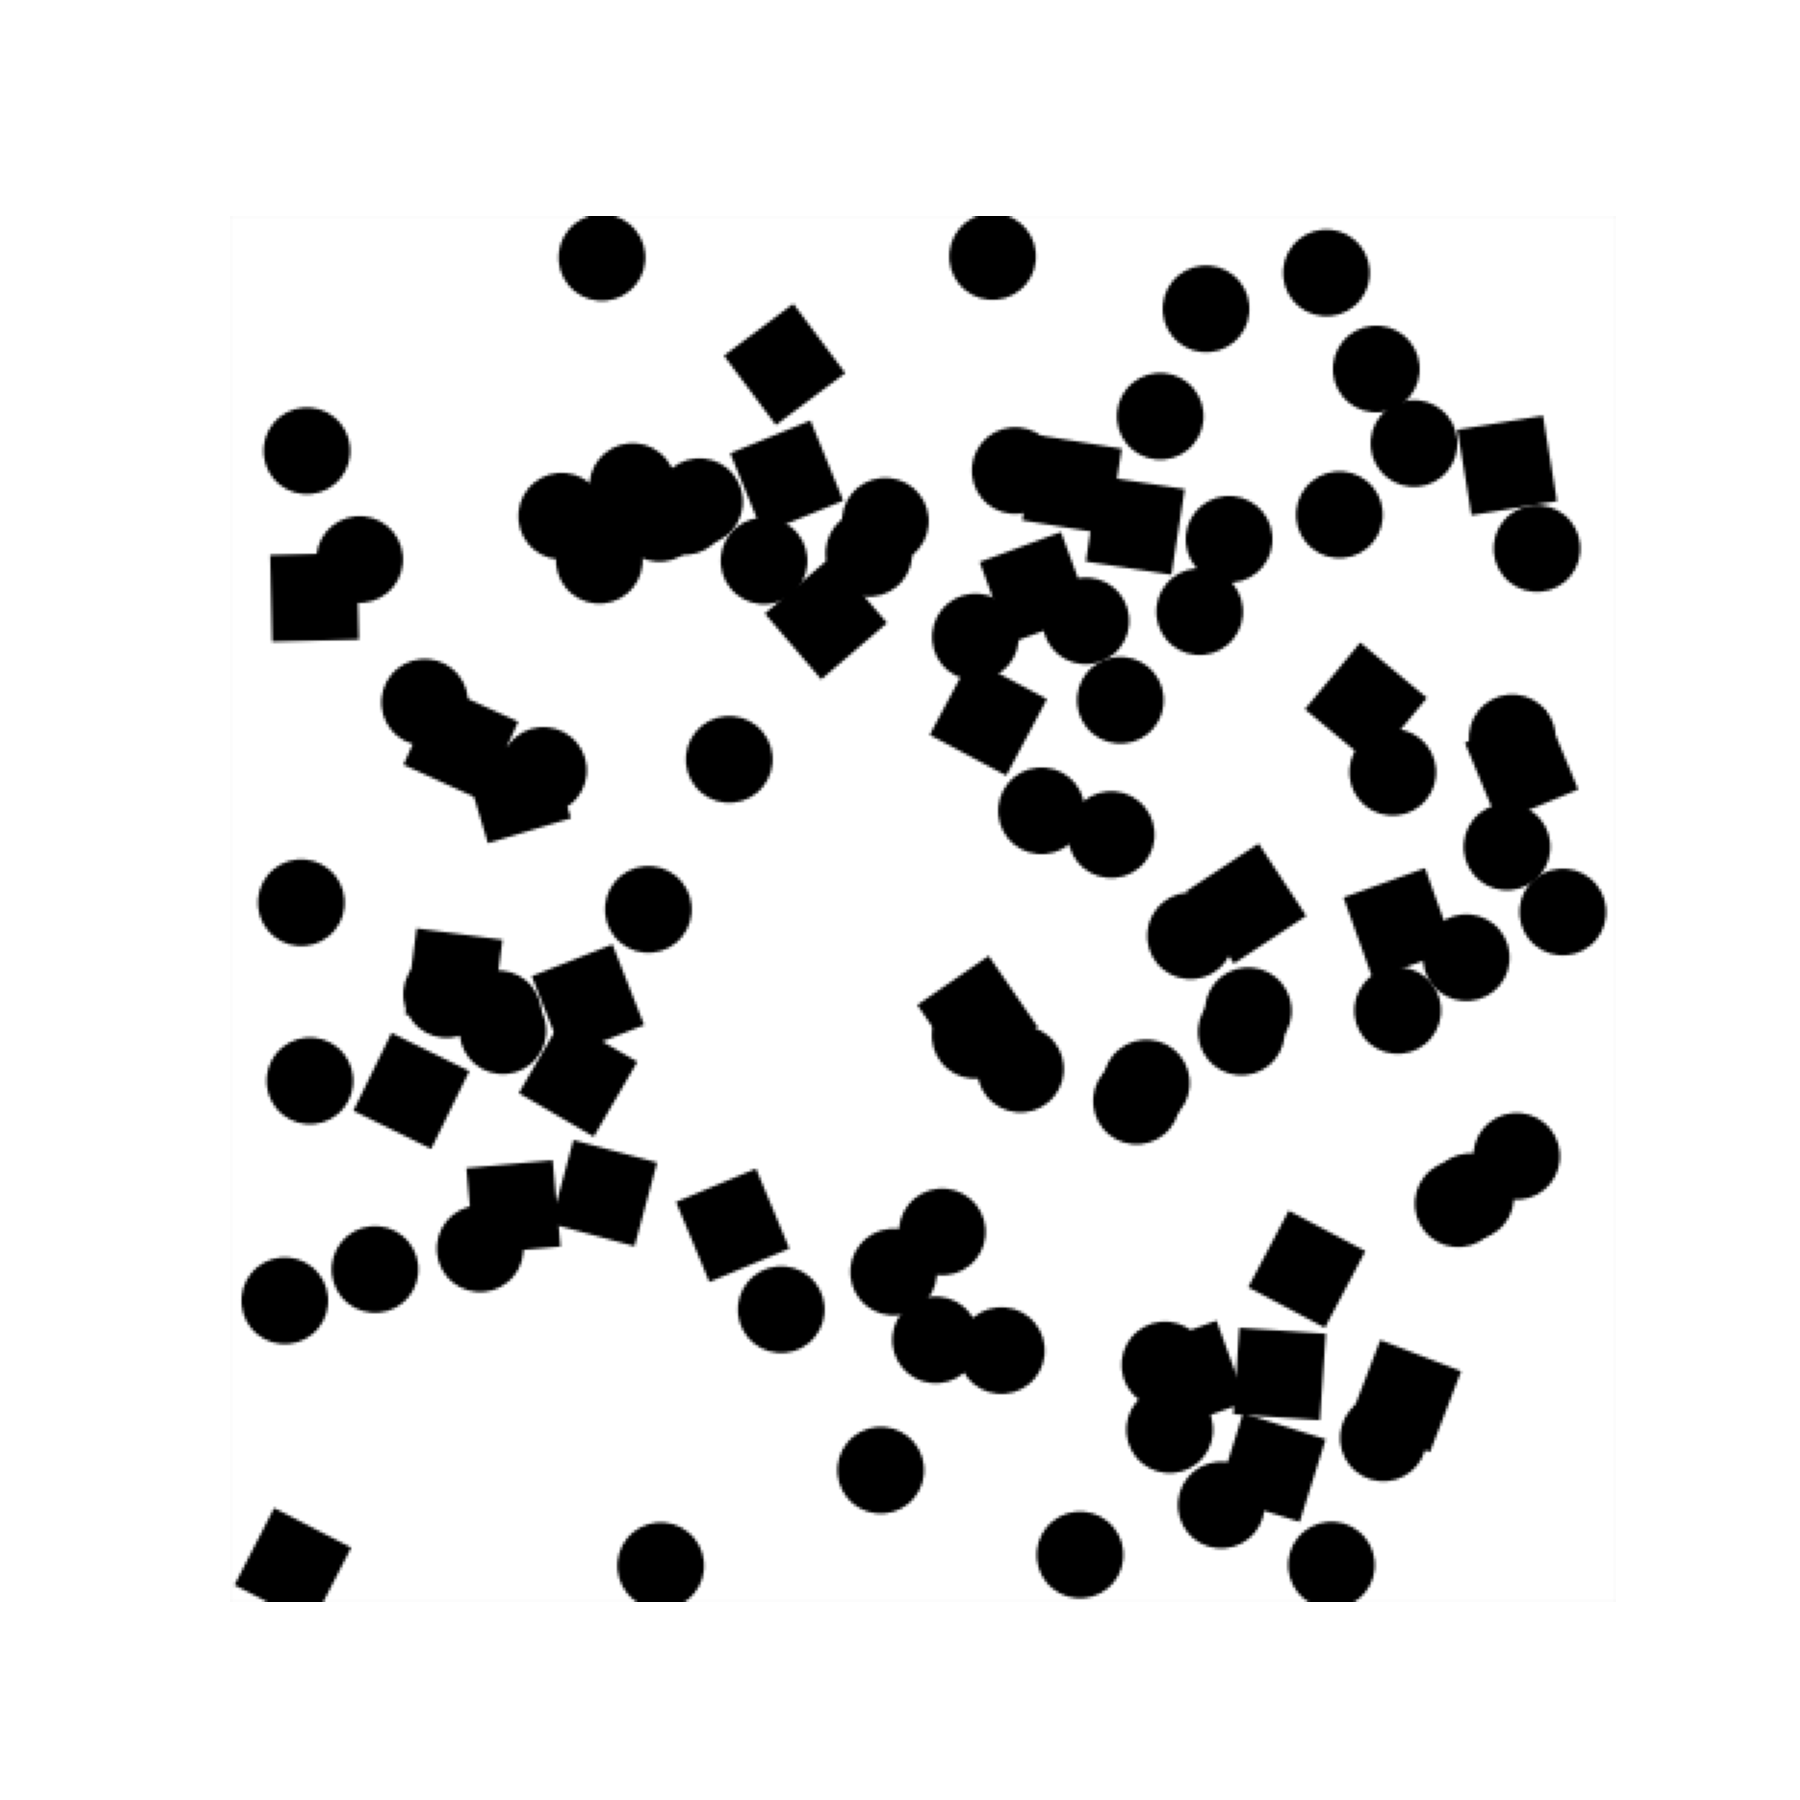

(-0.5, 479.5, 479.5, -0.5)

In [45]:
# Plot the patches
envType = 'forest' # 'maze4'
env_num = 300
envFolder = f'data/{envType}/val/env{env_num:06d}'
MazeMap = io.imread(osp.join(envFolder, f'map_{env_num}.png'), as_gray=True)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(MazeMap, cmap='gray')
ax.axis('off')

## Define the Start and Goal Point

Define your own start and goal point or choose a path from the validation data

<IPython.core.display.Javascript object>


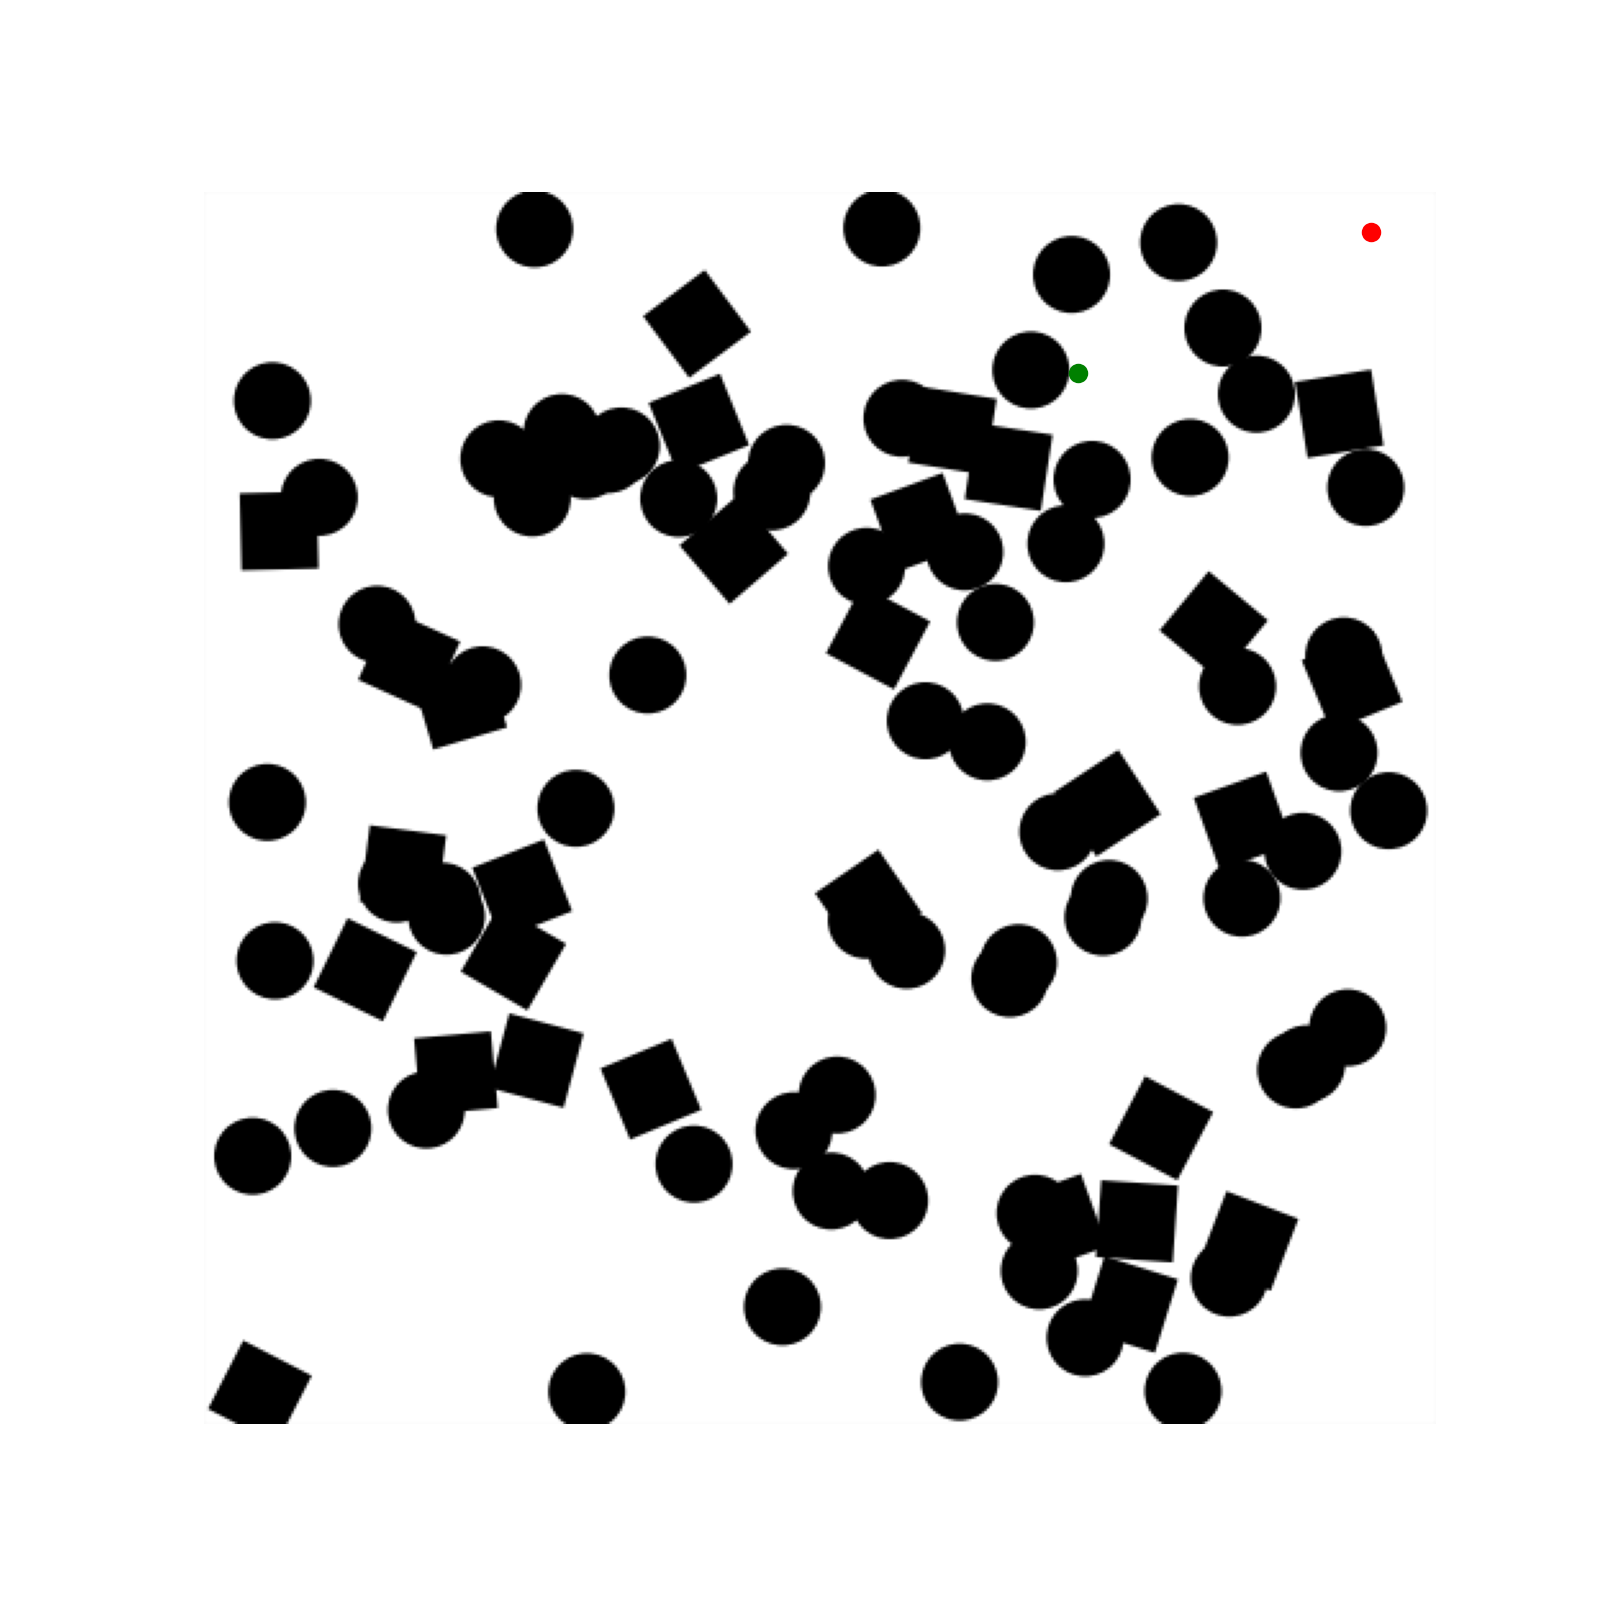

(-0.5, 479.5, 479.5, -0.5)

In [58]:
# Plot the path
pathNum = 4
data = pickle.load(open(osp.join(envFolder, f'path_{pathNum}.p'), 'rb'))
path = data['path_interpolated']

goal_pos = geom2pix(path[0, :])
start_pos = geom2pix(path[-1, :])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(MazeMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Generate the Patch

In [59]:
patch_map, predProb = get_patch(transformer, start_pos, goal_pos, MazeMap)

/home/yrf/MPT/.venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


<IPython.core.display.Javascript object>


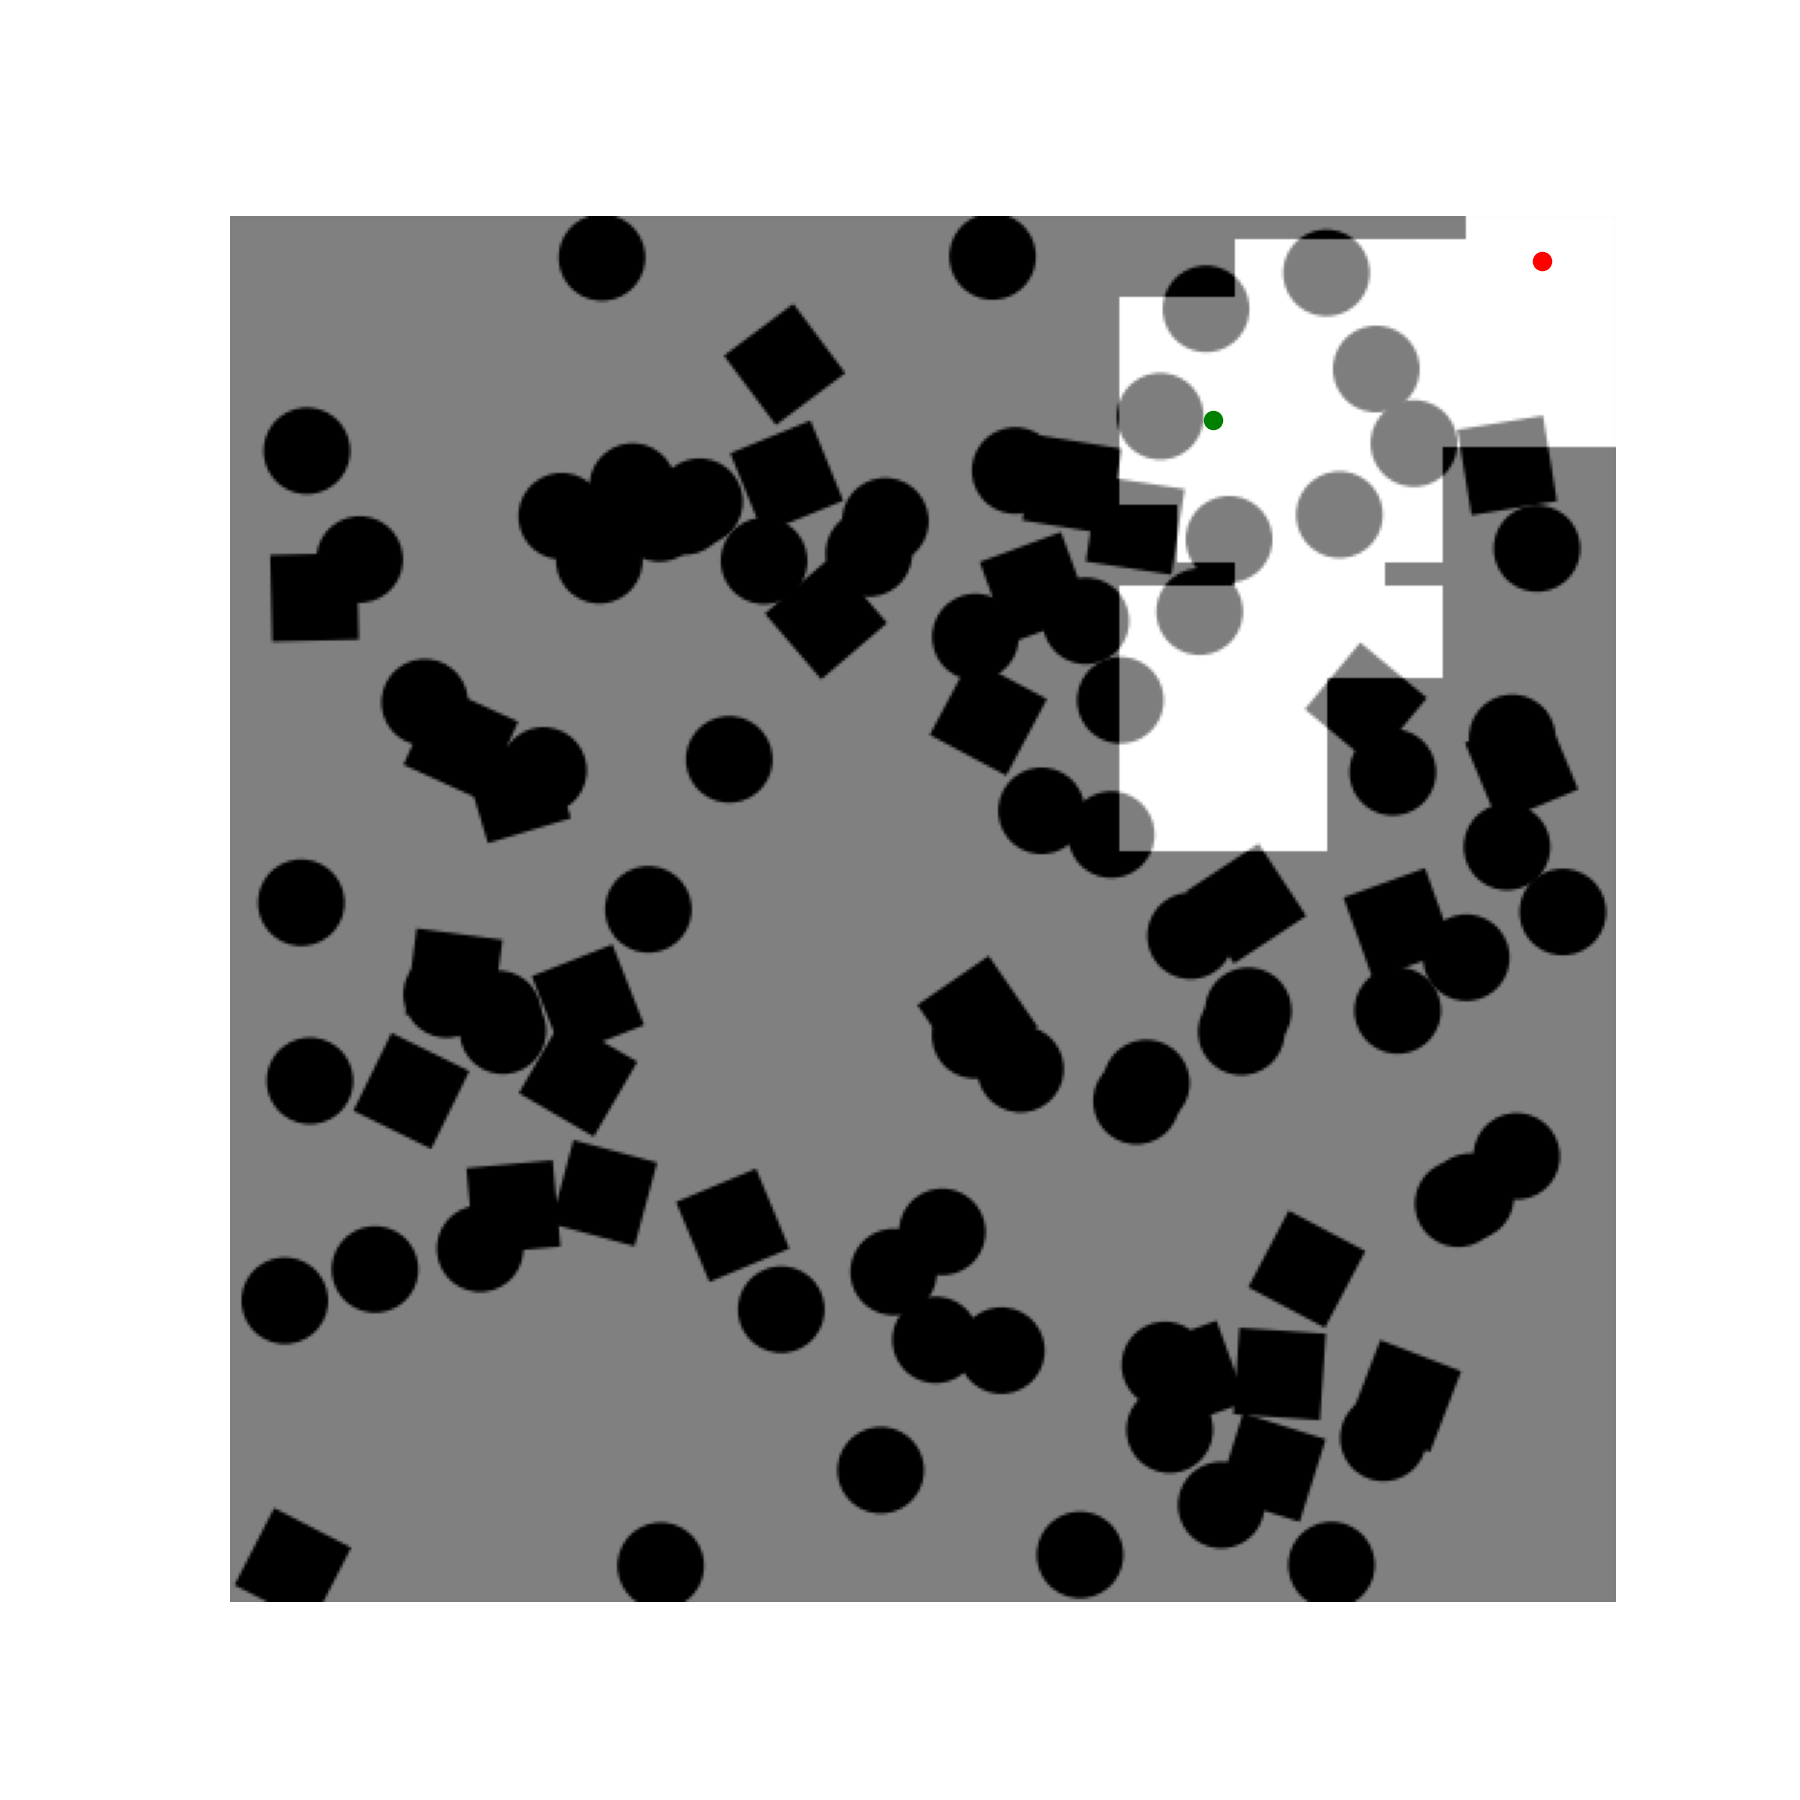

(-0.5, 479.5, 479.5, -0.5)

In [60]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Plan RRT* or IRRT* Path

Choose either RRT* or IRRT* to plan the path on the given patches.

In [61]:
cost = np.linalg.norm(np.diff(path, axis=0), axis=1).sum()

method = 'rrtstar' # or 'informedrrtstar'
# method = 'informedrrtstar'
MPTpath, t, v, success = get_path(path[0,:], path[-1, :], MazeMap, patch_map, method, cost)
# MPTpath, t, v, success = get_path(start_pos, goal_pos, MazeMap, patch_map, method, cost)

MPTpixelPos = np.array([geom2pix(pos) for pos in MPTpath])

Found Solution


In [62]:
pathPix = [geom2pix(pos) for pos in path]

uniqueId = []
for pos in pathPix:
    if pos not in uniqueId:
        uniqueId.append(pos)
pathPixelPos = np.array([geom2pix(pos) for pos in data['path']])# Generate Patch Maps
truePatchMap = np.zeros_like(MazeMap)
map_size = MazeMap.shape
receptive_field = 32
for pos in uniqueId:
    goal_start_x = max(0, pos[0]- receptive_field//2)
    goal_start_y = max(0, pos[1]- receptive_field//2)
    goal_end_x = min(map_size[0], pos[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], pos[1]+ receptive_field//2)
    truePatchMap[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

<IPython.core.display.Javascript object>


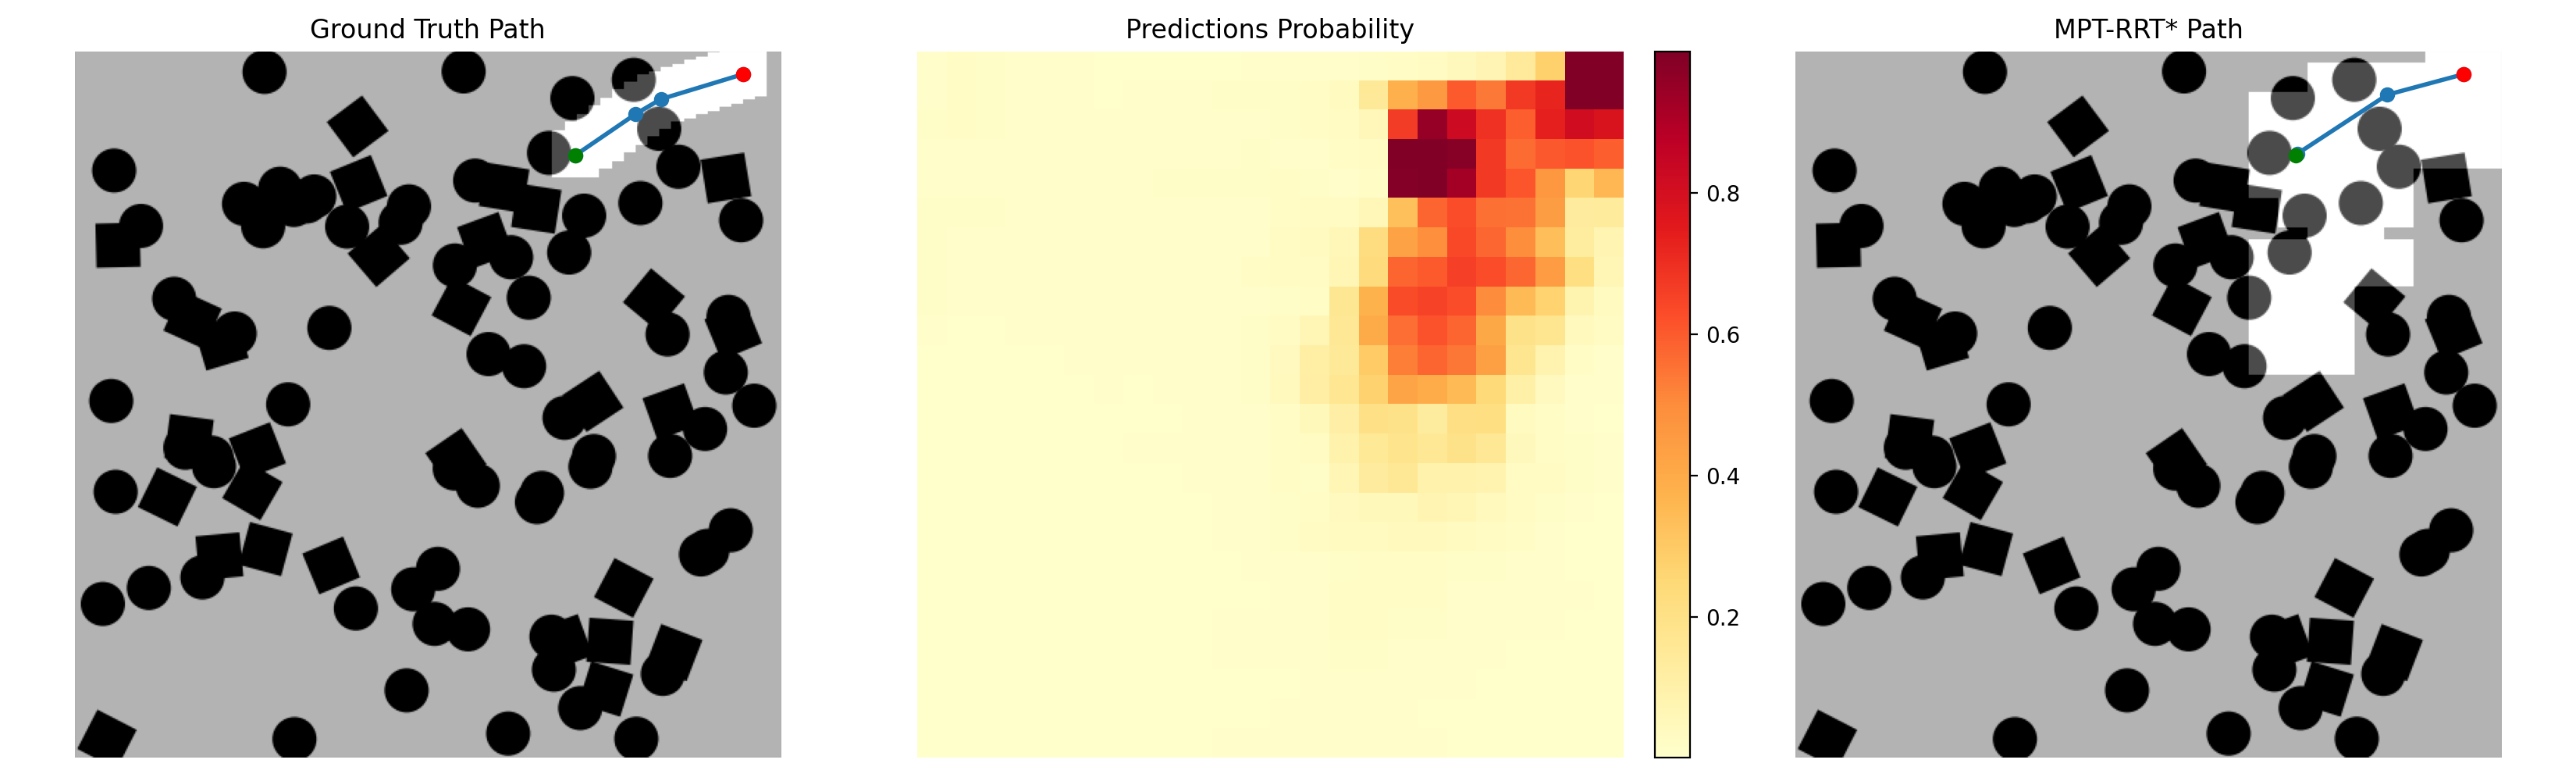

Saved visualization to predictions/forest/env000300_path_4_visualization.png


In [63]:
fig, ax = plt.subplots(1, 3, figsize=(16.5,5), dpi=100)

ax[0].set_title('Ground Truth Path')
ax[0].imshow(MazeMap, cmap='gray')
ax[0].imshow(truePatchMap, cmap='gray', alpha=0.3)
ax[0].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0].axis('off')

predMap = predProb[:, 1].cpu().detach().numpy()
im = ax[1].imshow(predMap.reshape((24, 24)), cmap="YlOrRd")
ax[1].set_title('Predictions Probability')
ax[1].axis('off')
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

ax[2].set_title('MPT-RRT* Path')
ax[2].imshow(MazeMap, cmap='gray')
ax[2].imshow(patch_map, cmap='gray', alpha=0.3)
ax[2].plot(MPTpixelPos[:,0], MPTpixelPos[:,1], marker='o', linewidth=2)
ax[2].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[2].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[2].axis('off')
plt.tight_layout(w_pad=0.1)

output_folder = 'predictions'
target_dir = osp.join(output_folder, envType)

if not osp.exists(target_dir):
    os.makedirs(target_dir, exist_ok=True)

plt.savefig(osp.join(target_dir, f'env{env_num:06d}_path_{pathNum}_visualization.png'), dpi=300)
print(f'Saved visualization to {osp.join(target_dir, f"env{env_num:06d}_path_{pathNum}_visualization.png")}')

## Car Robot

### Load Trained Model

In [ ]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = '/root/data/car_robot'
car_robot = True
epoch = 69

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.Transformer(**model_param)
_ = transformer.to(device)

In [ ]:
checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

In [ ]:
# Plot the patches
env_num = 1
envFolder = f'/root/data/forest_car/val/env{env_num:06d}'
MazeMap = io.imread(osp.join(envFolder, f'map_{env_num}.png'), as_gray=True)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(MazeMap, cmap='gray')
ax.axis('off')

In [ ]:
# Plot the path
pathNum = 0
data = pickle.load(open(osp.join(envFolder, f'path_{pathNum}.p'), 'rb'))
path = data['path_interpolated']

goal_pos = geom2pix(path[0, :])
start_pos = geom2pix(path[-1, :])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(MazeMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Generate Patch Map

In [ ]:
patch_map, predProb = get_patch(transformer, start_pos[::-1], goal_pos[::-1], MazeMap)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Plan SST Path

In [ ]:
MPTpath, t, _, success = get_path_sst(path[0,:], path[-1, :], MazeMap, patch_map)

### Visualize Planned Trajectory

In [ ]:
from matplotlib.patches import Circle
def geom2pix(pos, res=0.05, size=(480, 480)):
    """ Copied from utils
    """
    return (np.int(np.floor(pos[0]/res)), np.int(size[0]-1-np.floor(pos[1]/res)))

def plot_traj(path, ax=plt,
              robot_color='C0', 
              start_color='g',
              goal_color='r',
              orientation_color='orange',
              footprint=False, res = 0.05, robot_radius=0.2):
    """A function plotting trajectories
    """
    inds = np.array([geom2pix(s) for s in path])
    robot_ind_size = robot_radius/res
    if footprint:
        for i in range(len(inds)):
            ind = inds[i]
            if i == 0:
                ax.add_patch(Circle(ind, robot_ind_size, color=start_color, zorder=3, alpha=1))
            elif i >= len(inds) - 1:
                ax.add_patch(Circle(ind, robot_ind_size, color=goal_color, zorder=3, alpha=1))
            else:
                ax.add_patch(Circle(ind, robot_ind_size, zorder=3))
            theta = -path[i][2]
            head_ind = [ind[0] + np.cos(theta) * robot_ind_size*2, ind[1] + np.sin(theta) * robot_ind_size*2]
            ax.plot([ind[0], head_ind[0]], [ind[1], head_ind[1]], c=orientation_color, zorder=4)
    ax.plot(inds[:, 0], inds[:, 1], c=robot_color, marker='o', linewidth=2)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
plot_traj(MPTpath, ax=ax, footprint=True)
ax.axis('off')